# SHAP

In [1]:
import shap

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

from src.features.build_features import custom_encoder, FeatureEngineer 

/home/elie/miniconda3/envs/sentiment_analysis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/elie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load data + preprocessing

Some changes are applied for the SHAP usage because it will take too long otherwise(too many features):
* Removed ngram from Feature Enginnering COunt Vectorizer to make visualisation better.
* Only use 40 train and test samples.

In [2]:
train_data = pd.read_csv("../data/raw/train.txt",delimiter=';',names=['text','label'])[:40]
test_data = pd.read_csv("../data/raw/test.txt",delimiter=';',names=['text','label'])[:40]

feature_engineer = FeatureEngineer()
feature_engineer.count_vectorizer = CountVectorizer()
feature_engineer.fit(train_data['text'])
train_texts = feature_engineer.transform(train_data['text']).toarray()
test_texts = feature_engineer.transform(test_data['text']).toarray()

train_labels = custom_encoder(train_data['label'])
test_labels = custom_encoder(test_data['label'])

## Create and train model

In [3]:
model = RandomForestClassifier()
model.fit(train_texts, train_labels)

RandomForestClassifier()

## Transform texts into datarame

In [4]:
X_train = pd.DataFrame(data=train_texts, columns=feature_engineer.count_vectorizer.get_feature_names_out())
X_test = pd.DataFrame(data=test_texts, columns=feature_engineer.count_vectorizer.get_feature_names_out())

In [5]:
X_train.head()

,able,acceptable,accepted,acutely,agent,alone,already,also,always,amount,...,wish,without,word,work,would,write,writer,writing,wrong,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## SHAP Explanation

#### Build a TreeExplainer and compute Shaplay Values

In [6]:
explainer = shap.TreeExplainer(model)

#### Visualize explanations for a specific point of your data set

In [7]:
i = 0
data = X_test.iloc[i]

sentence = test_data['text'][i]
label = test_data['label'][i]
print(f'Sentence is : {sentence}')
print(f'Label is : {label}')

shap.initjs()
shap_values = explainer.shap_values(data)
shap.force_plot(explainer.expected_value[1], shap_values[1], data)

Sentence is : im feeling rather rotten so im not very ambitious right now
Label is : sadness


The predicted value is 0.27, closer to the negative sentiment, matching the actual label of sadness.

* The values in blue are responsible for lowering the prediction
* The value in red are responsible for increasing the prediction

#### Visualize explanations for all points of your data set at once

In [8]:
data = X_test

shap.initjs()
shap_values = explainer.shap_values(data)
shap.force_plot(explainer.expected_value[1], shap_values[1], data)

This plot helps us visualize the impact of every word on the prediction of the sentiment in the sentence.

We can filter on the left by the word, to see for every instance in our test set, the impact of this word. 

#### Visualize a summary plot for each class on the whole dataset

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


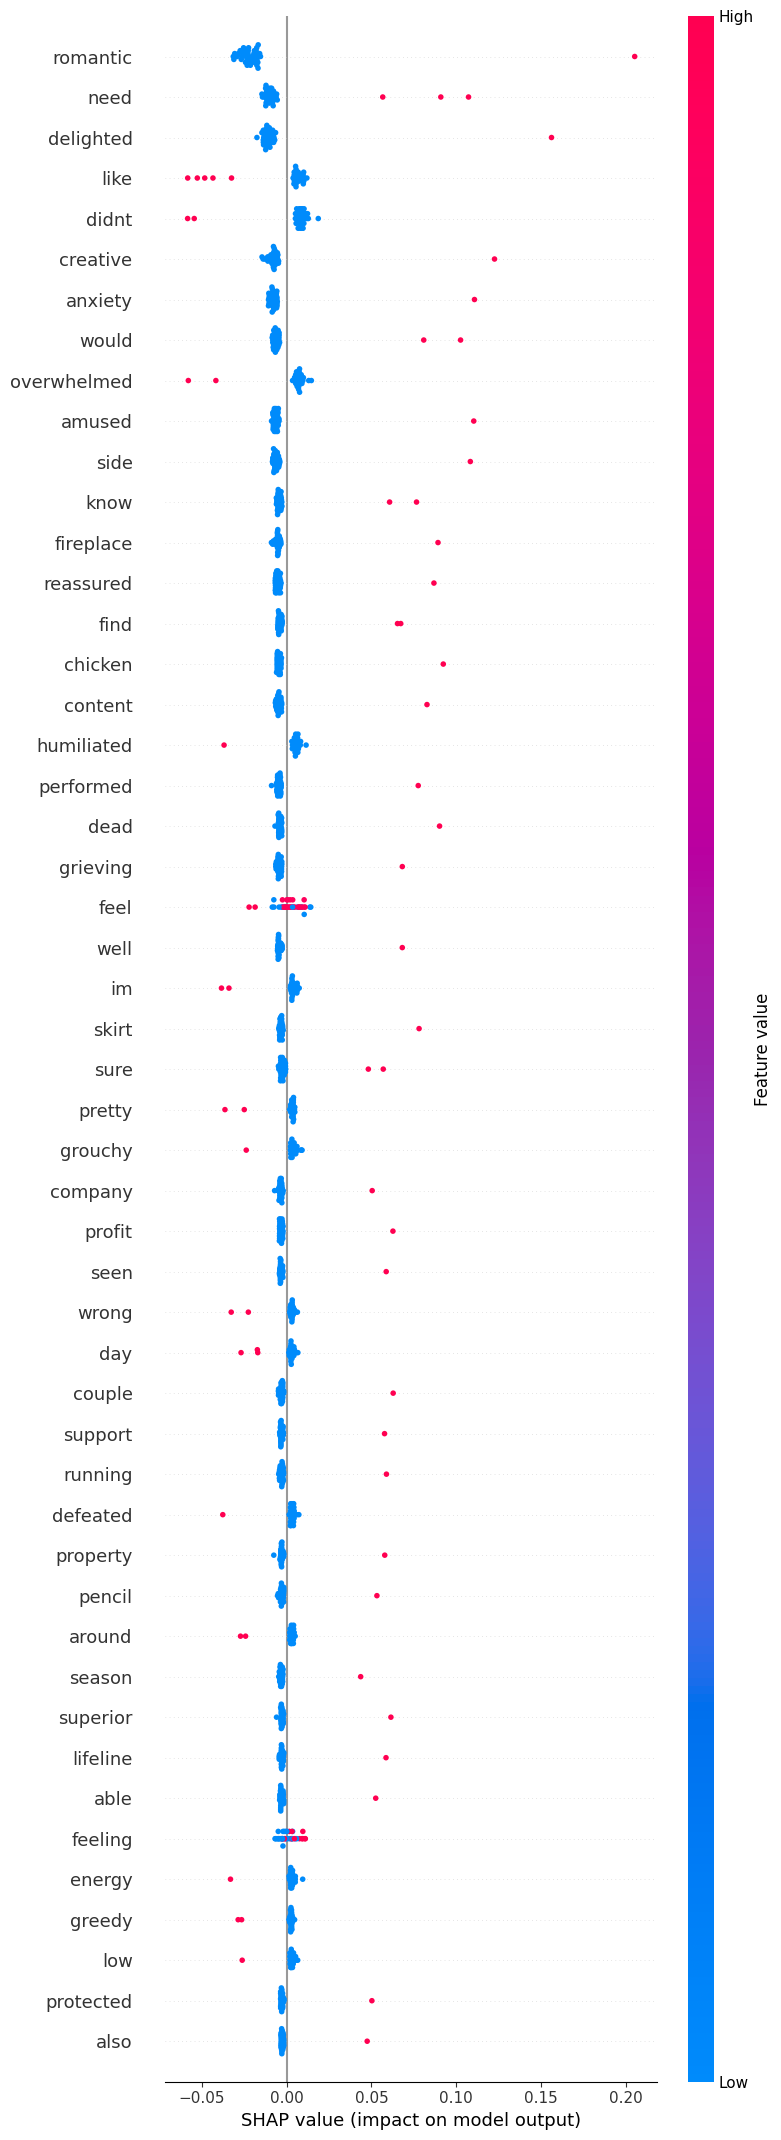

In [9]:
data = X_train

shap.initjs()
shap_values = explainer.shap_values(data)
shap.summary_plot(shap_values[1],data, max_display=50)

In this plot, we can visualize the overall impact of a word on the sentiment in a sentence. 

For example:
* "overwhelmed" and defeated have a negative impact on the sentiment (the red points are positioned on the left)
* "content" and "perfectly" have a positive impact (the red points are positioned on the right)